In [401]:
import os
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

api_key = os.environ.get("GOOGLE_API_KEY")
api_key_tavily = os.environ.get("TAVILY_API_KEY")
genai.configure(api_key=api_key)

os.environ["GOOGLE_API_KEY"] = api_key
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature = 0.5)

In [399]:
from langchain.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import create_react_agent

search = DuckDuckGoSearchResults()
tools = [search]
agent_executor = create_react_agent(llm, tools, prompt = "You are a helpful assistant. You MUST be 100 percent sure about your answer, otherwise use your tools.")

In [400]:
agent_executor.invoke({"messages" : [("user","Who is the current US president?")]})

{'messages': [HumanMessage(content='Who is the current US president?', additional_kwargs={}, response_metadata={}, id='8b024237-ba8b-437a-b3a3-6ebfb5158218'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'duckduckgo_results_json', 'arguments': '{"query": "current US president"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--bcc12c64-7025-4fbf-81a2-29da0b57d97c-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'current US president'}, 'id': '1962cd86-0778-4eea-8527-ab087f229b56', 'type': 'tool_call'}], usage_metadata={'input_tokens': 74, 'output_tokens': 11, 'total_tokens': 85, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content="Error: DuckDuckGoSearchException(RatelimitException('https://html.duckduckgo.com/html 202 Ratelimit'))\n Please fix your mistakes.", name='duckduckgo_results_json', id='da0bf7d1-01e4-4542-9b62-ac8b7f6e8680', to

In [368]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    answers : Annotated[List[str], operator.add]
    response : str

In [369]:
from pydantic import BaseModel, Field
from typing import List


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(description="different steps to follow, should be in sorted order")

In [390]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """For the given objective, come up with a step-by-step plan, even if some steps may be hard to execute. 
Do NOT respond with an apology or refusal. Make assumptions if needed, but return steps regardless."""
    ),
    ("placeholder", "{messages}")
])
planner = planner_prompt | llm.with_structured_output(Plan)

In [391]:
planner.invoke(
    {
        "messages": [
            ("user", "Who is the current US president and what is his age?")
        ]
    }
)

Plan(steps=['Find the current US president.', 'Find the current age of the US president.'])

In [392]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. Once you have done every step, return an empty list.
"""
)


replanner = replanner_prompt | llm.with_structured_output(Plan)


In [393]:
class Response(BaseModel):
    """Response to user."""

    response: str = Field(description="Final answer to the user.")

final_response_prompt = ChatPromptTemplate.from_template(
    """
Your objective was this:
{input}

Your original plan was this:
{plan}

You have answered the steps with the following responses:
{answers}

Using all these information, provide a final answer to the user.
"""
)

finalizer = final_response_prompt | llm.with_structured_output(Response)

In [394]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}.
Please make sure the result is up-to-date as of 2025. Prefer official or reliable sources with publication dates."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )

    response = agent_response["messages"][-1].content
    return {
        "past_steps": [(task, response)],
        "answers": [response]
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    return {"plan": output.steps}


async def should_end(state: PlanExecute) -> Literal["agent", "final_response"]:
    if not state["plan"]:  # Plan exhausted, we're done
        return "final_response"
    else:
        return "agent"
    
async def response(state: PlanExecute):
    final_answer = await finalizer.ainvoke(state)
    return {"response" : final_answer.response}


In [395]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_node("final_response", response)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

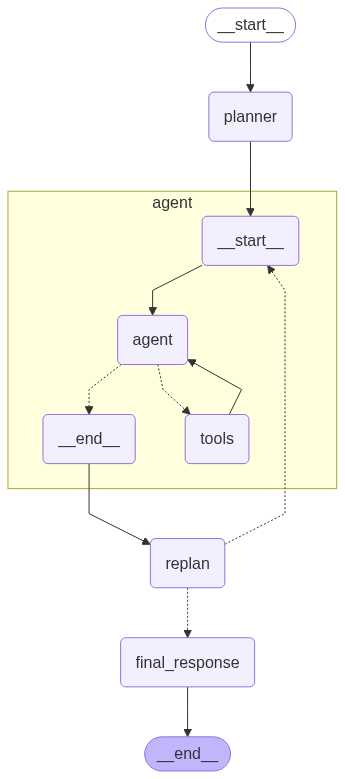

In [396]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [385]:
config = {"recursion_limit": 20}
hard_question = "Find out who the current US president and UK prime minister are. Then summarize each of their economic policy goals based on official statements or recent news."
inputs = {"input": hard_question}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(k, v)

planner {'plan': ['Find the current US president and their economic policy goals. ', 'Find the current UK prime minister and their economic policy goals. ', 'Summarize the economic policy goals of both leaders.']}
agent {'past_steps': [('Find the current US president and their economic policy goals. ', 'Based on the search results, it appears Donald Trump is the US president in 2025. His economic policy goals seem to include:\n\n*   Ending unconstitutional censorship by the federal government.\n*   Placing core national interests as the guiding mission of American foreign policy.\n*   Imposing individualized reciprocal higher tariffs on countries with which the United States has the largest trade deficits.')], 'answers': ['Based on the search results, it appears Donald Trump is the US president in 2025. His economic policy goals seem to include:\n\n*   Ending unconstitutional censorship by the federal government.\n*   Placing core national interests as the guiding mission of American f

In [398]:
config = {"recursion_limit": 20}
question = "How do i set a tavily api key in a windows variable? Step by step please."
inputs = {"input": question}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(k, v)

planner {'plan': ['1. Open System Properties: Right-click on the Windows Start button and select "System". Alternatively, search for "System" in the Start Menu and open it.', '2. Access Environment Variables: In the System window, click on "Advanced system settings" (usually on the left). In the System Properties window that appears, click the "Environment Variables..." button.', '3. Create a New User Variable: In the Environment Variables window, under the "User variables for [Your Username]" section, click the "New..." button.', '4. Enter Variable Name and Value: In the New User Variable window, enter "TAVILY_API_KEY" as the Variable name and your actual Tavily API key as the Variable value.', '5. Apply Changes: Click "OK" to close the New User Variable window. Click "OK" to close the Environment Variables window. Click "OK" to close the System Properties window.', '6. Verify the Variable (Optional): Open a new Command Prompt or PowerShell window. Type "echo %TAVILY_API_KEY%" and pre